<a href="https://colab.research.google.com/github/pcur/AI_Text_Detection/blob/main/GloVecEmbedder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import tensorflow as tf
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Real Time ML Final Project/tweetData'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
nRowsRead = None # specify 'None' if want to read whole file
# test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/drive/MyDrive/Real Time ML Final Project/data/completeTWEETdataset.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'test.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 21465 rows and 2 columns


In [5]:
df1.head(5)

,text,account.type
0,justin timberlake really one of the goats if y...,human
1,Thank you @PMBhutan for your gracious prayers ...,human
2,Theory: the number of red lights you will hit ...,human
3,Might give the BASIC #10Liner game contest ano...,human
4,Fifty Four Degrees sent it was,bot


In [6]:

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

# Encode labels to 0 and 1
df1 = df1.replace("human", "0")
df1 = df1.replace("bot", "1")

 # Convert labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df1["account.type"])

# One-hot encode labels
y_one_hot = to_categorical(y_encoded)

print(y_one_hot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


## Tokenization


In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

In [8]:
text_data = df1["text"].values
#class_data = df1["account.type"].values

In [9]:
# Tokenize the text using the Tokenizer class
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)

# Pad the sequences to ensure they all have the same length
MAX_SEQUENCE_LENGTH = 100
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Convert the text into word embeddings using pre-trained GloVe embeddings
EMBEDDING_DIM = 100
glove_model = api.load("glove-wiki-gigaword-100")
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = glove_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(
    sequences, y_one_hot, test_size=0.1, random_state=42
)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42
)

## CNN

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [15]:
# Convert the tokenized text sequences to padded sequences
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D

# Define the maximum number of words to consider in the embedding layer
MAX_NUM_WORDS = 33966

# Define the dimensionality of the embedding layer
EMBEDDING_DIM = 100

# Define the maximum length of the input sequences
MAX_SEQUENCE_LENGTH = 100

# Define the number of classes
NUM_CLASSES = 2

# Define the CNN model
# model = Sequential()
# model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(2, activation='sigmoid'))
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(16, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
483/483 [==============================] - 8s 8ms/step - loss: 0.5244 - accuracy: 0.6798 - val_loss: 0.4967 - val_accuracy: 0.7120
Epoch 2/10
483/483 [==============================] - 5s 11ms/step - loss: 0.4872 - accuracy: 0.7273 - val_loss: 0.4918 - val_accuracy: 0.7244
Epoch 3/10
483/483 [==============================] - 3s 5ms/step - loss: 0.4641 - accuracy: 0.7478 - val_loss: 0.4846 - val_accuracy: 0.7301
Epoch 4/10
483/483 [==============================] - 3s 5ms/step - loss: 0.4390 - accuracy: 0.7659 - val_loss: 0.4964 - val_accuracy: 0.7239
Epoch 5/10
483/483 [==============================] - 3s 5ms/step - loss: 0.4150 - accuracy: 0.7876 - val_loss: 0.4928 - val_accuracy: 0.7236
Epoch 6/10
483/483 [==============================] - 3s 6ms/step - loss: 0.3904 - accuracy: 0.8050 - val_loss: 0.5286 - val_accuracy: 0.7091
Epoch 7/10
483/483 [==============================] - 3s 7ms/step - loss: 0.3616 - accuracy: 0.8225 - val_loss: 0.5589 - val_accuracy: 0.7140
Epoch

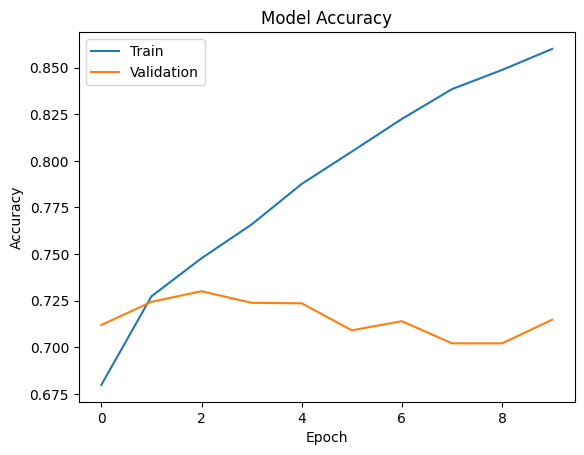

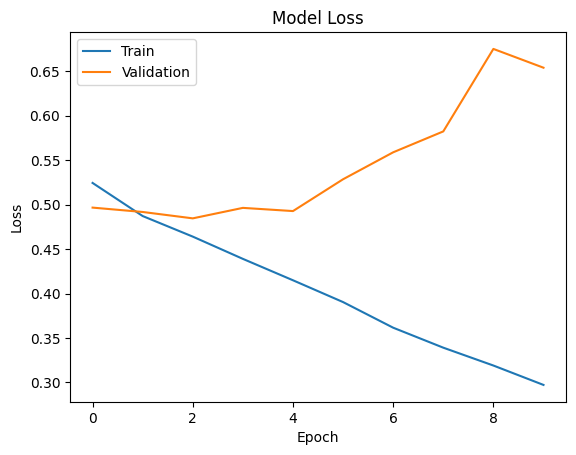

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


68/68 [==============================] - 0s 3ms/step


Text(50.722222222222214, 0.5, 'True Labels')

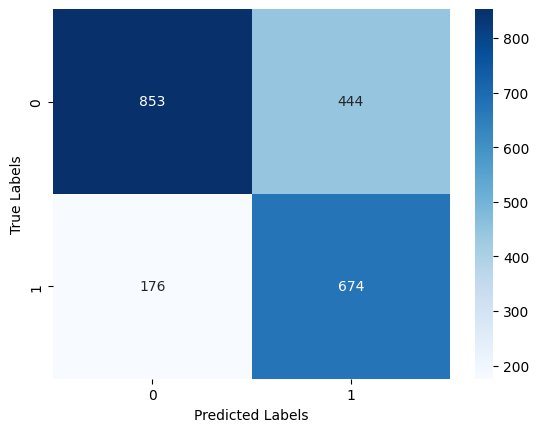

In [18]:
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import seaborn as sns

# Get predictions on validation set
y_test_pred = model.predict(X_test)

# Convert predictions to binary (0/1) format
y_test_pred_binary = np.argmax(y_test_pred, axis=1)

# Convert true labels to binary (0/1) format
y_test_binary = np.argmax(y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_binary, y_test_pred_binary)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


#Using RNN Instead of CNN

In [19]:
def buildRNN(dropout_val):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NUM_WORDS,
                              EMBEDDING_DIM, 
                              input_length=MAX_SEQUENCE_LENGTH, 
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout_val),
    tf.keras.layers.Dense(2)
  ])
  return model


In [25]:
accHistOverLR = np.empty(0)
for learning_rate in range(1, 20,5):
  RNNmodel = buildRNN(0.4)
  RNNmodel.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate*0.0001),
              metrics=['accuracy'])
  history = RNNmodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))  
  accHistOverLR = np.append(accHistOverLR, history.history['val_accuracy'][-1])

Epoch 1/10
483/483 [==============================] - 19s 21ms/step - loss: 0.5972 - accuracy: 0.6532 - val_loss: 0.5205 - val_accuracy: 0.7076
Epoch 2/10
483/483 [==============================] - 10s 21ms/step - loss: 0.5165 - accuracy: 0.7007 - val_loss: 0.5006 - val_accuracy: 0.7140
Epoch 3/10
483/483 [==============================] - 10s 20ms/step - loss: 0.4999 - accuracy: 0.7124 - val_loss: 0.4957 - val_accuracy: 0.7182
Epoch 4/10
483/483 [==============================] - 9s 18ms/step - loss: 0.4951 - accuracy: 0.7151 - val_loss: 0.4951 - val_accuracy: 0.7197
Epoch 5/10
483/483 [==============================] - 9s 19ms/step - loss: 0.4910 - accuracy: 0.7200 - val_loss: 0.4896 - val_accuracy: 0.7246
Epoch 6/10
483/483 [==============================] - 9s 20ms/step - loss: 0.4875 - accuracy: 0.7208 - val_loss: 0.4851 - val_accuracy: 0.7308
Epoch 7/10
483/483 [==============================] - 9s 18ms/step - loss: 0.4829 - accuracy: 0.7279 - val_loss: 0.4832 - val_accuracy: 0.7

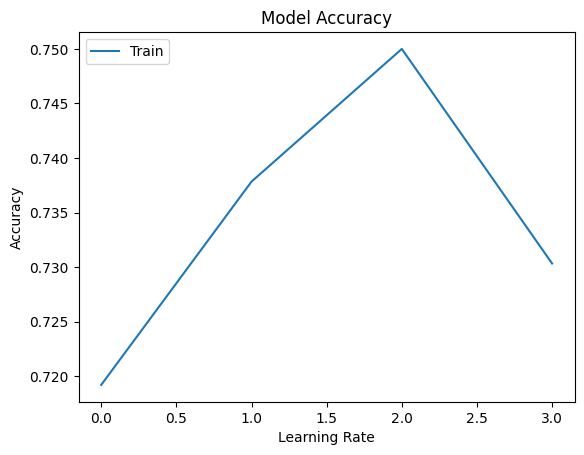

In [26]:
# Plot training and validation accuracy
plt.plot(accHistOverLR)
plt.title('Model Accuracy')

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
  RNNmodel = buildRNN(0.4)
  RNNmodel.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(.001),
              metrics=['accuracy'])
  history = RNNmodel.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))  

Epoch 1/10
483/483 [==============================] - 20s 23ms/step - loss: 0.5225 - accuracy: 0.6916 - val_loss: 0.4965 - val_accuracy: 0.7112
Epoch 2/10
483/483 [==============================] - 9s 20ms/step - loss: 0.4978 - accuracy: 0.7111 - val_loss: 0.4908 - val_accuracy: 0.7179
Epoch 3/10
483/483 [==============================] - 9s 18ms/step - loss: 0.4832 - accuracy: 0.7231 - val_loss: 0.4838 - val_accuracy: 0.7223
Epoch 4/10
483/483 [==============================] - 10s 21ms/step - loss: 0.4722 - accuracy: 0.7378 - val_loss: 0.4794 - val_accuracy: 0.7298
Epoch 5/10
483/483 [==============================] - 9s 19ms/step - loss: 0.4538 - accuracy: 0.7505 - val_loss: 0.4739 - val_accuracy: 0.7386
Epoch 6/10
483/483 [==============================] - 8s 17ms/step - loss: 0.4377 - accuracy: 0.7641 - val_loss: 0.4732 - val_accuracy: 0.7381
Epoch 7/10
483/483 [==============================] - 10s 21ms/step - loss: 0.4196 - accuracy: 0.7737 - val_loss: 0.4817 - val_accuracy: 0.7

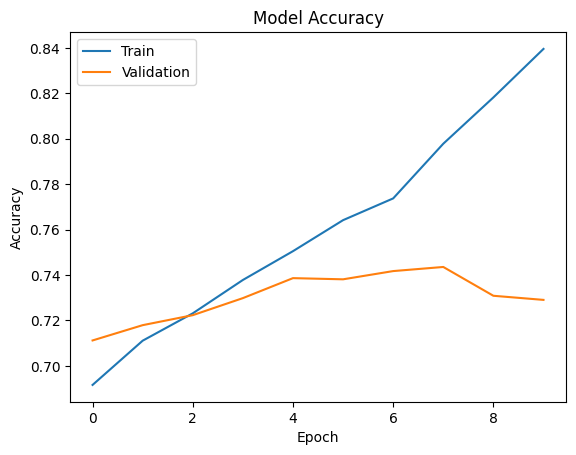

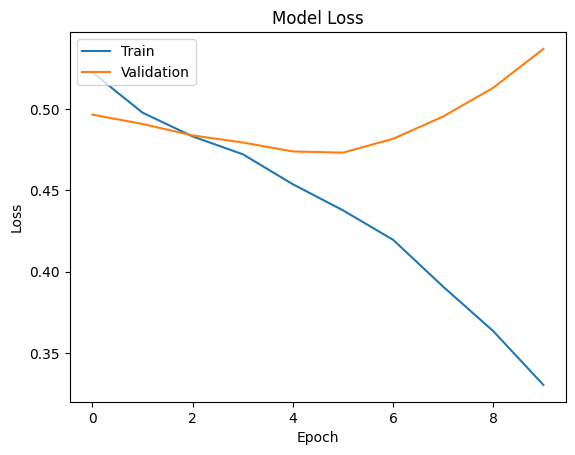

In [28]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

68/68 [==============================] - 2s 6ms/step


Text(50.722222222222214, 0.5, 'True Labels')

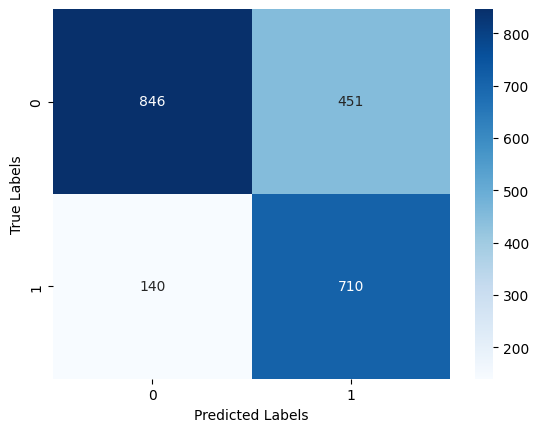

In [29]:
# Get predictions on test set
y_test_pred = RNNmodel.predict(X_test)

# Convert predictions to binary (0/1) format
y_test_pred_binary = np.argmax(y_test_pred, axis=1)

# Convert true labels to binary (0/1) format
y_test_binary = np.argmax(y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_binary, y_test_pred_binary)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
